### Conditional Image Generation using Variational Auto Encoder -Conditional GAN

#### Importing the requried libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataloader_mnist as dataloader_mnist

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.autograd import Variable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
print(device)

cuda


#### Coding up the Variational Auto Encoder (VAE) -> (Encoder + Decoder)

In [ ]:
class VAE_encoder(nn.Module):

    def __init__(self, input_channels,hidden_vec_size,input_len, input_width,num_classes):
        """
        input_channels = number of channels in input image
        input_size = L * W = input_len * input_width
        hidden_vec_size=latent vector dimension
        num_classes = number of classes in the dataset
        
        """
        super(VAE_encoder,self).__init__()

        self.input_channels=input_channels
        self.input_len=input_len
        self.input_width=input_width
        self.hidden_vec_size=hidden_vec_size
        self.num_classes=num_classes

        input_size=self.input_len * self.input_width

        # Encoder Block

        self.encoder=nn.Sequential(
            # total input_channels = input_channels + 1 -> RGB +label encoding (originially)
            nn.Conv2d(self.input_channels+1,32,stride=1,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32,64,stride=2,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(64,128,stride=2,kernel_size=3,padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(128,128,stride=1,kernel_size=3,padding=1),
            nn.Flatten(),
            nn.Linear(((self.input_len//4)*(self.input_width//4)*128),300)
        )

                

        # Latent vector 

        self.z_mean= nn.Linear(300, self.hidden_vec_size)
        self.z_log_var = nn.Linear(300,self.hidden_vec_size)

       
    
    def forward(self,X,y):
       # y=torch.argmax(y,dim=1).reshape((y.shape[0],1,1,1))
        #y=torch.ones(X.shape)*y
        # print('before')
        # print(y.shape)
        # print('after')
        label=torch.zeros((X.shape[0], 10))
        label=label
        label[torch.arange(X.shape[0]),y]=1
        label=torch.tensor(label)
        label=torch.argmax(label,dim=1).reshape((label.shape[0],1,1,1))
        label = torch.ones(X.shape)*label
        # print(X.shape)
        # print(label.shape)
        X_concat=torch.cat((X,label.to(device)),dim=1)
        # print(X_concat.shape)

        X_concat=self.encoder(X_concat)
        X_concat=X_concat.reshape((X_concat.shape[0],-1))

        X_concat=F.relu(X_concat)
        mean_vec=self.z_mean(X_concat)
        log_var_vec=self.z_log_var(X_concat)


        return mean_vec,log_var_vec

# Decoder Block

class VAE_decoder(nn.Module):
    def __init__(self,input_channels,hidden_vec_size,input_len, input_width,num_classes):
        super(VAE_decoder,self).__init__()

        self.input_channels=input_channels
        self.input_len=input_len
        self.input_width=input_width
        self.hidden_vec_size=hidden_vec_size
        self.num_classes=num_classes

        input_size=self.input_len * self.input_width

        self.decoder_1=nn.Sequential(
            nn.Linear(self.hidden_vec_size,300 ),
            nn.Linear(300,(self.input_len//4)*(self.input_width//4)*128 ),
        )
        self.decoder_2=nn.Sequential(
            nn.ConvTranspose2d(128, 128, stride=1, kernel_size=3, padding=1),
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(128, 64, stride=2, kernel_size=3, padding=1),                
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(64, 32, stride=2, kernel_size=4, padding=0),                
            nn.LeakyReLU(0.01),
            nn.ConvTranspose2d(32, 1, stride=1, kernel_size=3, padding=1), 
            # Convert.convert(input_len, input_width), 
        )

    # def reparameterize(self, mean_vec, log_var_vec):
    #     std=torch.exp(0.5*log_var_vec)
    #     eps=torch.randn_like(std)
    #     return eps*std + mean_vec
    
    # def Unflatten(self, X):
    #     return X.reshape((X.shape[0],128,(self.input_len//4),(self.input_width//4)))
    
    def forward(self, z):

        decoder_z=self.decoder_1(z)
        decoder_z=decoder_z.reshape((z.shape[0],128, self.input_len//4,self.input_width//4))
        decoder_z=self.decoder_2(decoder_z)
        return torch.tanh(decoder_z)

    # def forward(self,X,y):
    #     mean_vec, log_var_vec=self.encoder_forward(X,y)
    #     z=self.reparameterize(mean_vec,log_var_vec)

    #     # Encoding the class

    #     z=torch.cat((z, y.float()),dim=1)
    #     prediction=self.decoder_forward(z)

    #     return prediction, mean_vec,log_var_vec
    


In [ ]:
 # Class to reshape the vector into L*W*C type
 
class Reshape(nn.Module):
    def __init__(self,*args):
        super().__init__()
        self.shape=args

    def reshape(self, x):
        return x.view(self.shape)

 # Class to convert the image dimension back to original dimension

class Convert(nn.Module):
    def __init__(self):
        super().__init__()
    
    def convert(self, x, input_len, input_width):
        # Converts x to original image dimension
        return x[:,:,:input_len, :input_width]

#### Coding up the Discriminator (D)

In [ ]:
class discriminator(nn.Module):
    def __init__(self,input_channels,num_classes,image_len,image_width):
        """
        input_channels = number of channels in input image
        num_classes = number of classes in the dataset
        image_len =length of image
        image_width = width of image
        
        """

        super(discriminator,self).__init__()

        self.input_channels=input_channels
        self.num_classes=num_classes
        self.image_len=image_len
        self.image_width=image_width

        self.conv1=nn.Conv2d(input_channels+1,32,kernel_size=4,stride=2,padding=1)
        self.leaky_relu_1=nn.LeakyReLU(0.01)
        self.conv2=nn.Conv2d(32, 64,kernel_size=4,stride=2,padding=1)
        self.leaky_relu_2=nn.LeakyReLU(0.01)
        self.conv3=nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1 )
        self.leaky_relu_3=nn.LeakyReLU(0.01)
        self.lin_1=nn.Linear((image_len//4)*(image_width//4)*128,512)
        self.relu1=nn.ReLU()
        self.lin_2=nn.Linear(512, 1)
        self.sigmoid= nn.Sigmoid()
        
        
        #self.embed=nn.Embedding(num_classes,image_len*image_width)

    def forward(self,X, y):

        #embedding=self.embed(y).view(y.shape[0],1, self.image_len,self.image_width)
        label=np.zeros((X.shape[0], 10))
        label[np.arange(X.shape[0]),y]=1
        label=torch.tensor(label)
        label=torch.argmax(label,dim=1).reshape((label.shape[0],1,1,1))
        label = torch.ones(X.shape)*label
        X=torch.cat((X,label.to(device)),dim=1)

        #X=torch.cat([X,embedding],dim=1)
        X=self.leaky_relu_1(self.conv1(X))
        X=self.leaky_relu_2(self.conv2(X))
        X=self.leaky_relu_3(self.conv3(X))
        X=X.view(-1,128*(self.image_len//4)*(self.image_width//4))
        X_1=X
        X=self.relu1(self.lin_1(X))
        X=self.sigmoid(self.lin_2(X))
        
        return X, X_1



#### VAE-GAN Modeling

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class VAE_CGAN(nn.Module):
    def __init__(self,input_channels,hidden_vec_size,input_len, input_width,num_classes):
        super(VAE_CGAN,self).__init__()

        self.input_channels=input_channels
        self.num_classes=num_classes
        self.image_len=input_len
        self.image_width=input_width
        self.hidden_vec_size=hidden_vec_size
        
        self.encoder=VAE_encoder(self.input_channels,self.hidden_vec_size,self.image_len,self.image_width,self.num_classes)
        self.decoder=VAE_decoder(self.input_channels,self.hidden_vec_size,self.image_len,self.image_width,self.num_classes)

        self.discriminator=discriminator(self.input_channels,self.num_classes,self.image_len,self.image_width)

        self.encoder.apply(weights_init)
        self.decoder.apply(weights_init)
        self.discriminator.apply(weights_init)


    def forward(self,X,y):
        batch_size=X.size()[0]
        mean_z, logvar_z=self.encoder(X,y)
        std_dev=logvar_z.mul(0.5).exp_()

        # Getting epsilon from Normal distribution
        epsilon=Variable(torch.randn(batch_size,self.hidden_vec_size)).to(device)
        z=mean_z+std_dev*epsilon
        x_tilda=self.decoder(z)

        return mean_z,logvar_z,x_tilda

        

In [ ]:
def show(img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    #f = "./%s.png" % file_name
    fig = plt.figure(dpi=200)
    #fig.suptitle(file_name, fontsize=14, fontweight='bold')
    plt.imshow(npimg)
    #plt.imsave(f,npimg)

#### Training the Conditonal_VAE-Discriminator

In [ ]:
#data_loader = dataloader(64)
def train_CVAE_GAN(batch_size,input_channels,hidden_vec_size,input_len, input_width,num_classes,epochs,lr,gamma,dataloader):
    data_loader=dataloader
    vae_cgan=VAE_CGAN(input_channels,hidden_vec_size,input_len,input_width,num_classes).to(device)
    disc=discriminator(input_channels,num_classes,input_len,input_width).to(device)
    real_data_batch = next(iter(data_loader))

    criterion=nn.BCELoss().to(device)
    optim_Encoder=torch.optim.Adam(vae_cgan.encoder.parameters(), lr=lr)
    optim_Decoder=torch.optim.Adam(vae_cgan.decoder.parameters(), lr=lr)
    optim_Discriminator=torch.optim.Adam(disc.parameters(), lr=lr*0.1)

    z_init=Variable(torch.randn((batch_size,hidden_vec_size))).to(device)
    x_init=Variable(real_data_batch[0]).to(device)
    y_init=Variable(real_data_batch[1]).to(device)

    for epoch in range(epochs):
        prior_loss_list,gan_loss_list,reconstruction_loss_list=[],[],[]
        real_list_disc,fake_list_disc, prior_list_disc=[],[],[]
        print(epoch)
        for i, (data,y) in enumerate(data_loader,0):
            b_size = data.size()[0]

            ones_label=Variable(torch.ones(b_size,1)).to(device)
            zeros_label=Variable(torch.zeros(b_size,1)).to(device)
            zeros_label1=Variable(torch.zeros(b_size,1)).to(device)
            data_var = Variable(data).to(device)
            mean_z, logvar_z, recon = vae_cgan(data_var,y)
            z_p =  Variable(torch.randn(b_size,128)).to(device)
            x_p_tilda = vae_cgan.decoder(z_p)

            output = disc(data_var,y)[0]
            D_err_real = criterion(output, ones_label)
            real_list_disc.append(D_err_real.item())
            output = disc(recon,y)[0]
            D_err_recon = criterion(output, zeros_label)
            fake_list_disc.append(D_err_recon.item())
            output = disc(x_p_tilda,y)[0]
            D_err_recon_noise = criterion(output,zeros_label1)
            prior_list_disc.append(D_err_recon_noise.item())
            gan_loss = D_err_real + D_err_recon + D_err_recon_noise
            gan_loss_list.append(gan_loss.item())
            optim_Discriminator.zero_grad()
            gan_loss.backward(retain_graph = True)
            optim_Discriminator.step()

            output = disc(data_var,y)[0]
            D_err_real=criterion(output,ones_label)
            output=disc(recon,y)[0]
            D_err_recon=criterion(output,zeros_label)
            output=disc(x_p_tilda,y)[0]
            D_err_recon_noise=criterion(output,zeros_label1)
            gan_loss=D_err_real+D_err_recon+D_err_recon_noise

            x_l_tilda=disc(recon,y)[1]
            x_l=disc(data_var,y)[1]
            recon_loss=((x_l_tilda-x_l)**2).mean()
            err_dec=gamma*recon_loss-gan_loss
            reconstruction_loss_list.append(recon_loss.item())
            optim_Decoder.zero_grad()
            err_dec.backward(retain_graph=True)
            optim_Decoder.step()

            mean_z,logvar_z,recon=vae_cgan(data_var,y)
            x_l_tilda=disc(recon,y)[1]
            x_l=disc(data_var,y)[1]
            recon_loss=((x_l_tilda-x_l)**2).mean()
            prior_loss=1+logvar_z-mean_z.pow(2)-logvar_z.exp()
            prior_loss=(-0.5 * torch.sum(prior_loss))/torch.numel(mean_z.data)
            prior_loss_list.append(prior_loss.item())
            err_enc=prior_loss + 5*recon_loss

            optim_Encoder.zero_grad()
            err_enc.backward(retain_graph=True)
            optim_Encoder.step()

            if i%50==0:
                print('[%d/%d][%d/%d]\tLoss_gan: %.4f\tLoss_prior: %.4f\tRec_loss: %.4f\tdis_real_loss: %0.4f\tdis_fake_loss: %.4f\tdis_prior_loss: %.4f'
                  % (epoch,epochs, i, len(data_loader),
                     gan_loss.item(), prior_loss.item(),recon_loss.item(),D_err_real.item(),D_err_recon.item(),D_err_recon_noise.item()))
            
        b=vae_cgan(x_init,y_init)[2]
        b=b.detach()
        c=vae_cgan.decoder(z_init)
        c=c.detach()
        print("Noise image epoch {0}".format(epoch))
        show(make_grid((c*0.5+0.5).cpu(),8))
        print("Reconstructed image epoch {0}".format(epoch))
        show(make_grid((b*0.5+0.5).cpu(),8))







In [ ]:
data_loader_mnist=dataloader_mnist.Dataloader(60, 'MNIST')

0
[0/10][0/1000]	Loss_gan: 2.0332	Loss_prior: 0.0009	Rec_loss: 0.0013	dis_real_loss: 0.7575	dis_fake_loss: 0.6379	dis_prior_loss: 0.6379


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0/10][50/1000]	Loss_gan: 1.6863	Loss_prior: 0.0000	Rec_loss: 0.0015	dis_real_loss: 0.8381	dis_fake_loss: 0.4216	dis_prior_loss: 0.4266
[0/10][100/1000]	Loss_gan: 1.8658	Loss_prior: 0.0004	Rec_loss: 0.0029	dis_real_loss: 0.9213	dis_fake_loss: 0.4982	dis_prior_loss: 0.4463
[0/10][150/1000]	Loss_gan: 1.7103	Loss_prior: 0.0000	Rec_loss: 0.0028	dis_real_loss: 0.9867	dis_fake_loss: 0.3589	dis_prior_loss: 0.3648
[0/10][200/1000]	Loss_gan: 0.3556	Loss_prior: 0.0000	Rec_loss: 0.0086	dis_real_loss: 0.2034	dis_fake_loss: 0.0761	dis_prior_loss: 0.0761
[0/10][250/1000]	Loss_gan: 0.1000	Loss_prior: 0.0000	Rec_loss: 0.0168	dis_real_loss: 0.0429	dis_fake_loss: 0.0285	dis_prior_loss: 0.0285
[0/10][300/1000]	Loss_gan: 0.0483	Loss_prior: 0.0000	Rec_loss: 0.0198	dis_real_loss: 0.0257	dis_fake_loss: 0.0113	dis_prior_loss: 0.0113
[0/10][350/1000]	Loss_gan: 0.0175	Loss_prior: 0.0000	Rec_loss: 0.0241	dis_real_loss: 0.0086	dis_fake_loss: 0.0045	dis_prior_loss: 0.0045
[0/10][400/1000]	Loss_gan: 0.0094	Loss_pri

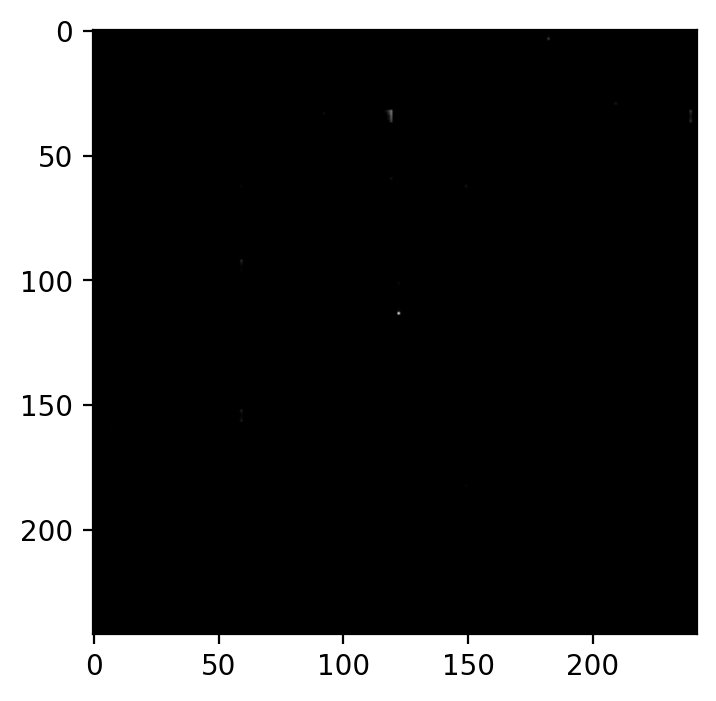

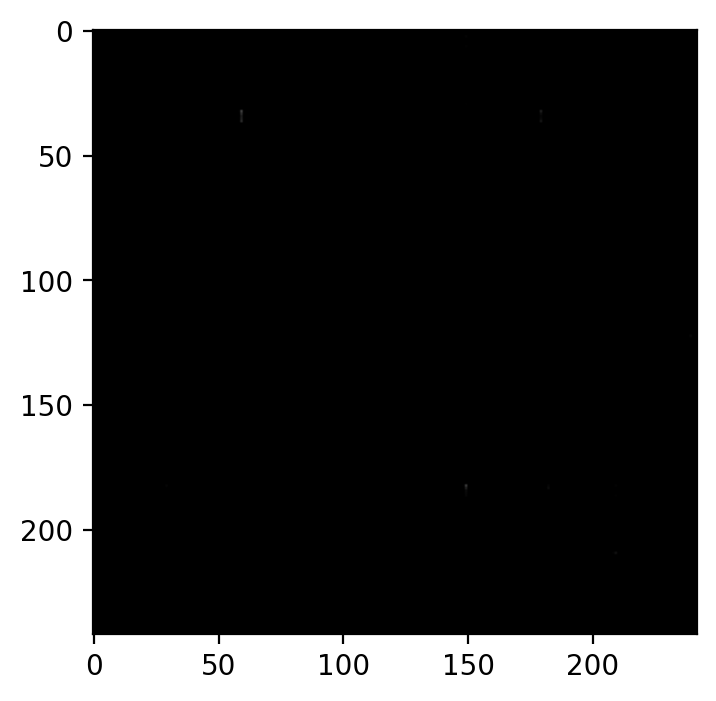

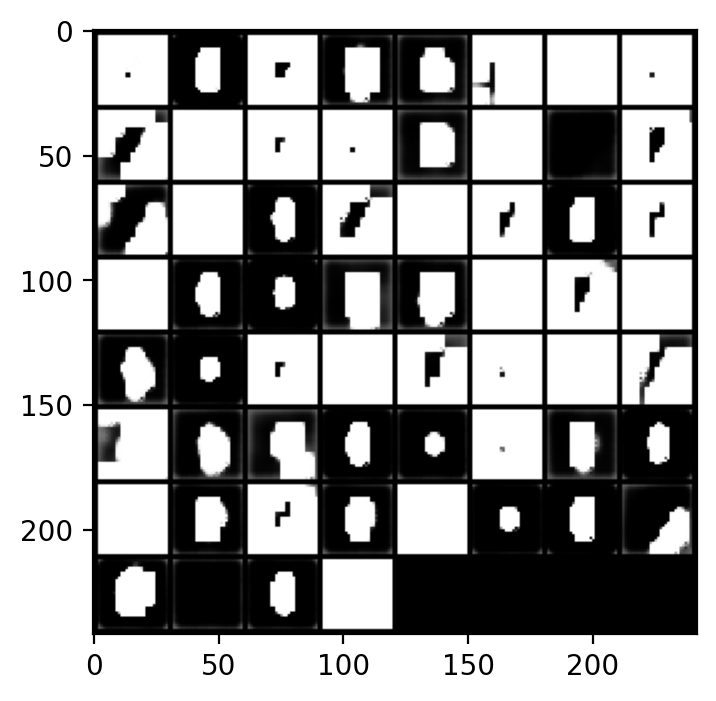

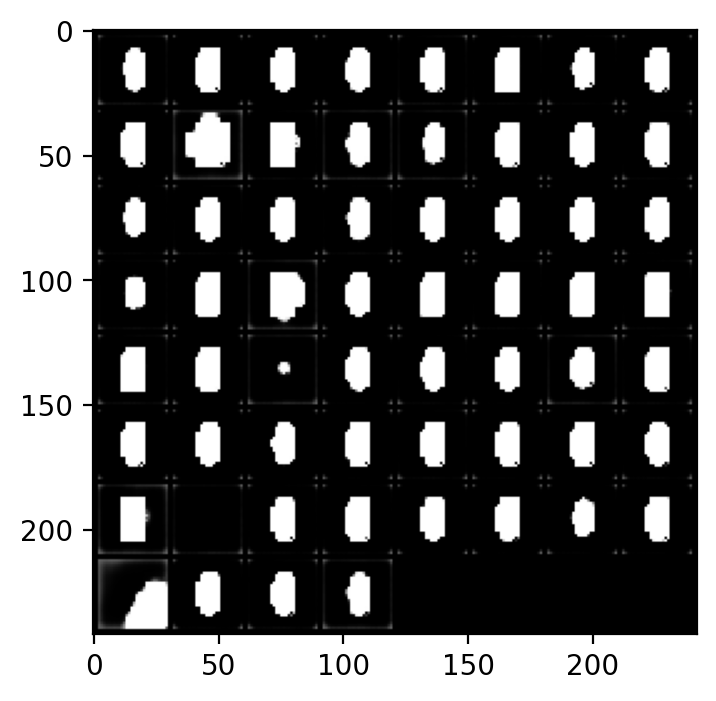

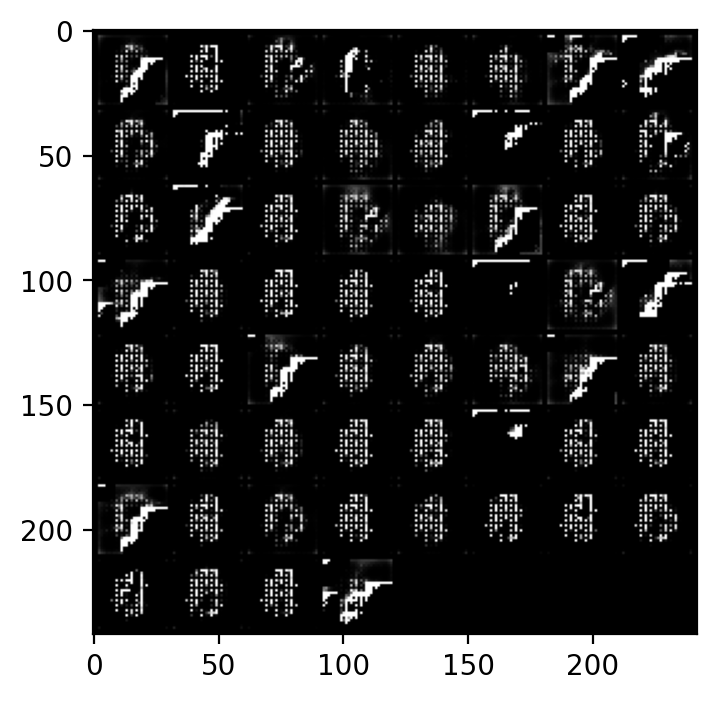

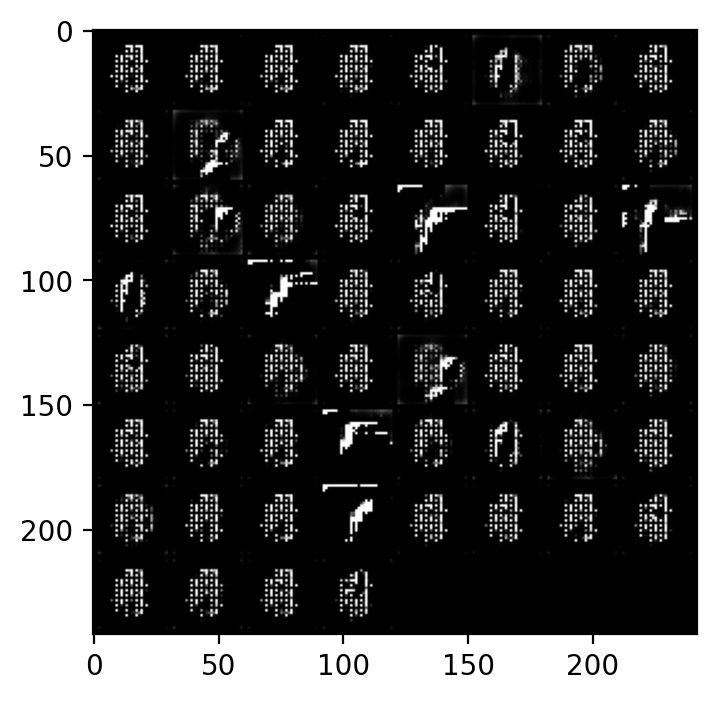

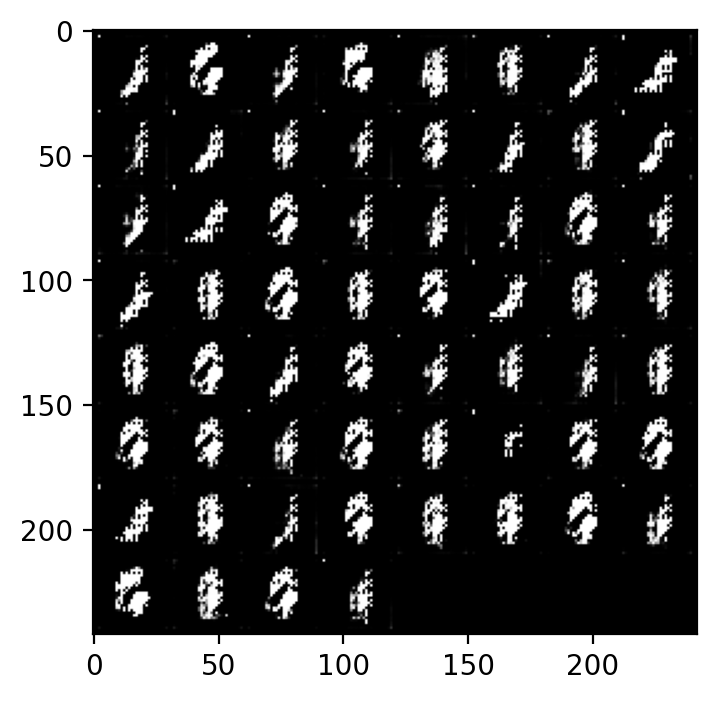

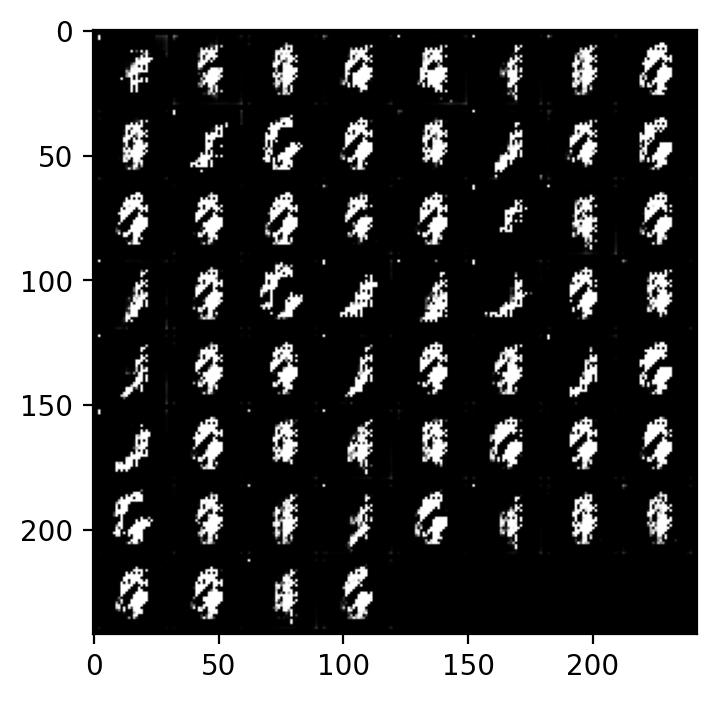

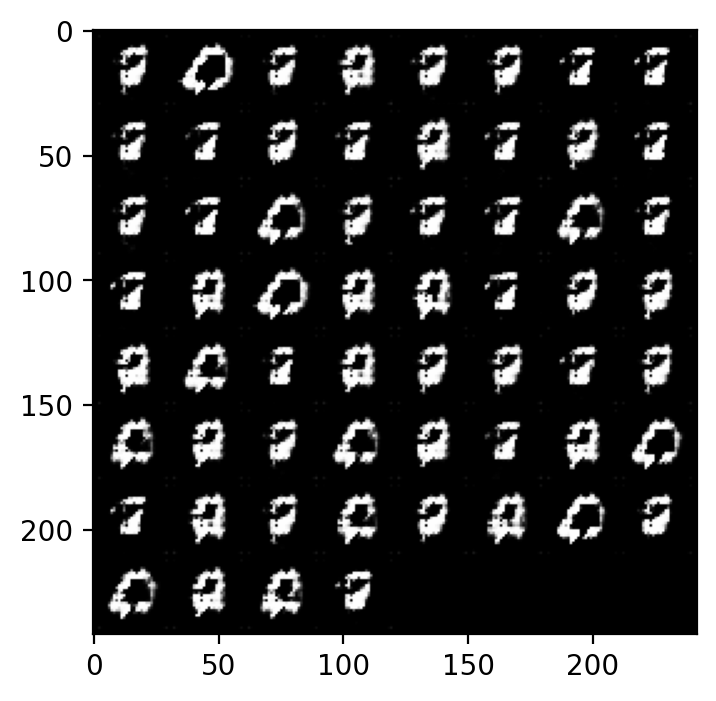

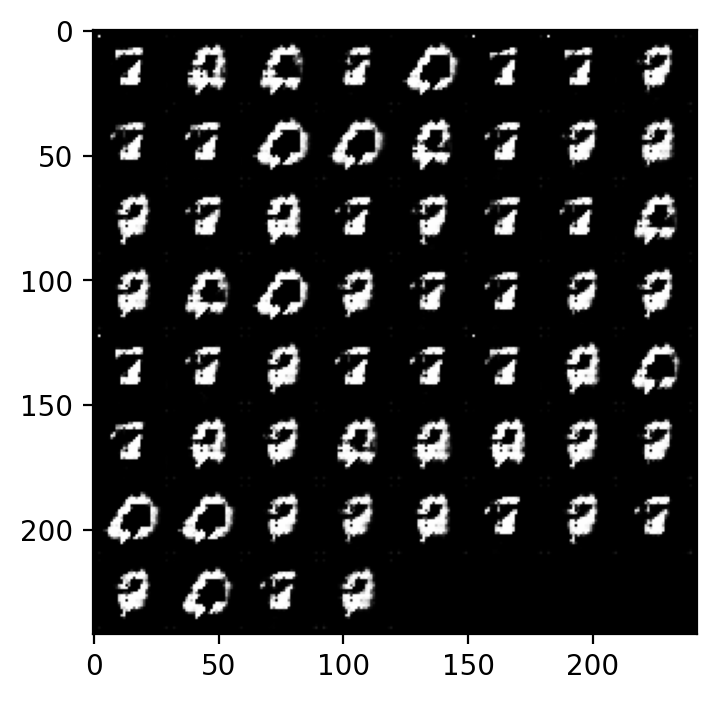

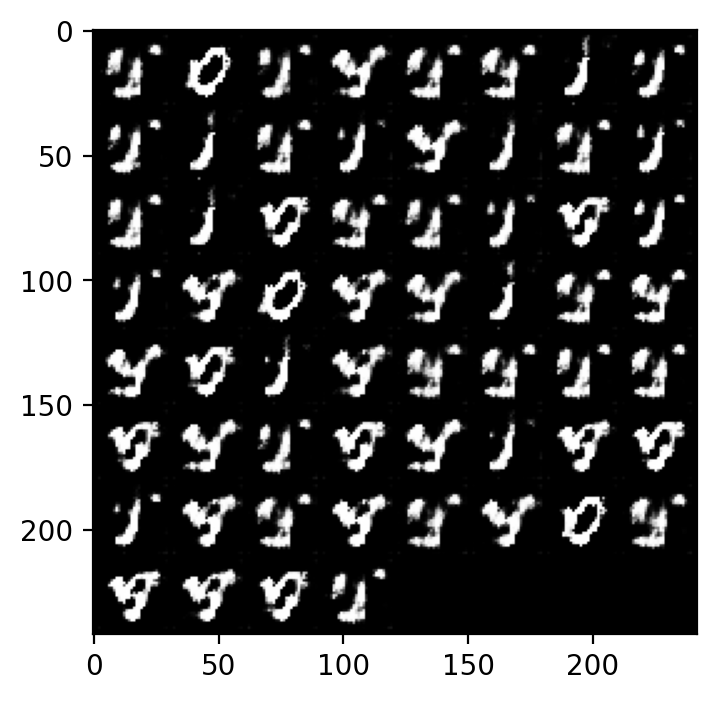

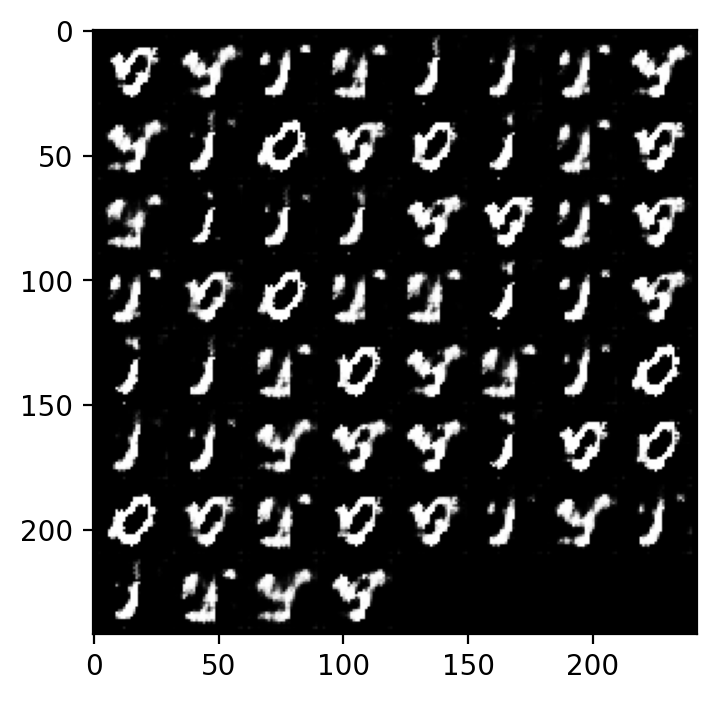

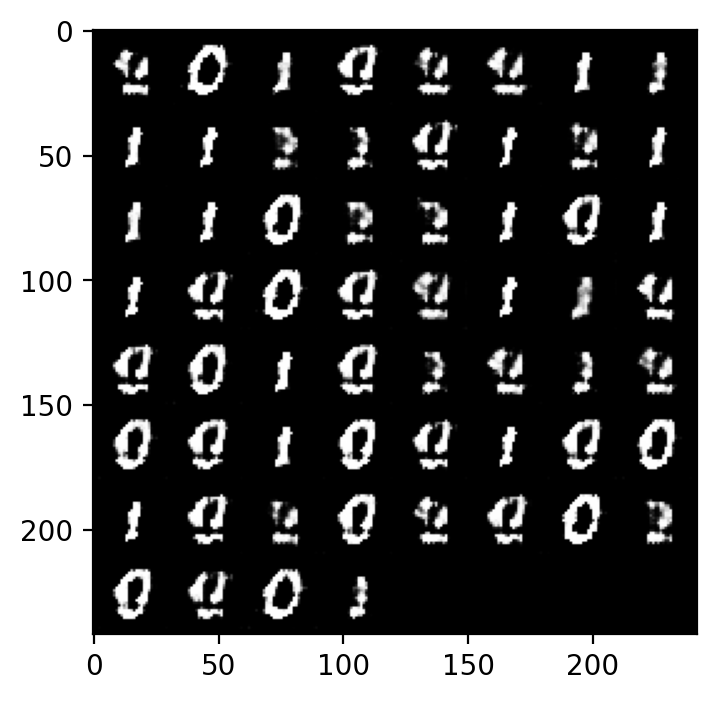

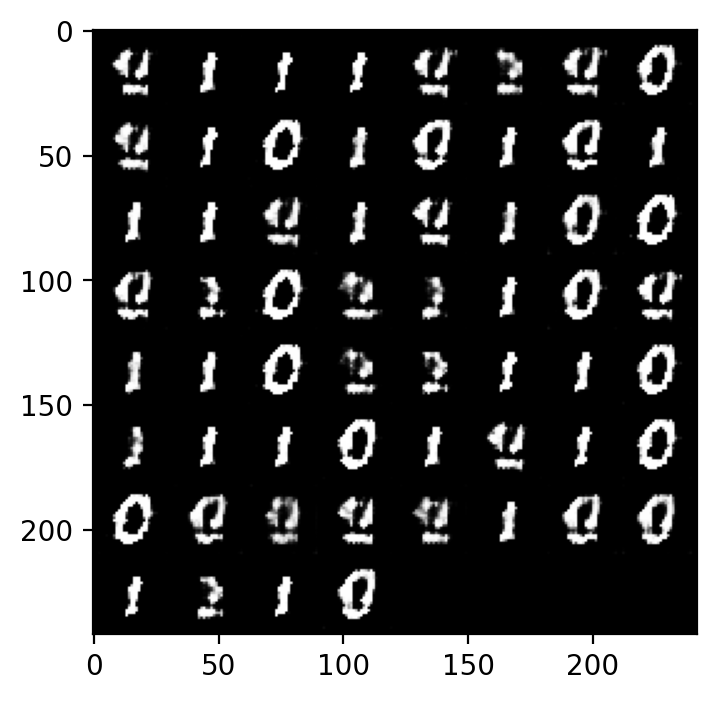

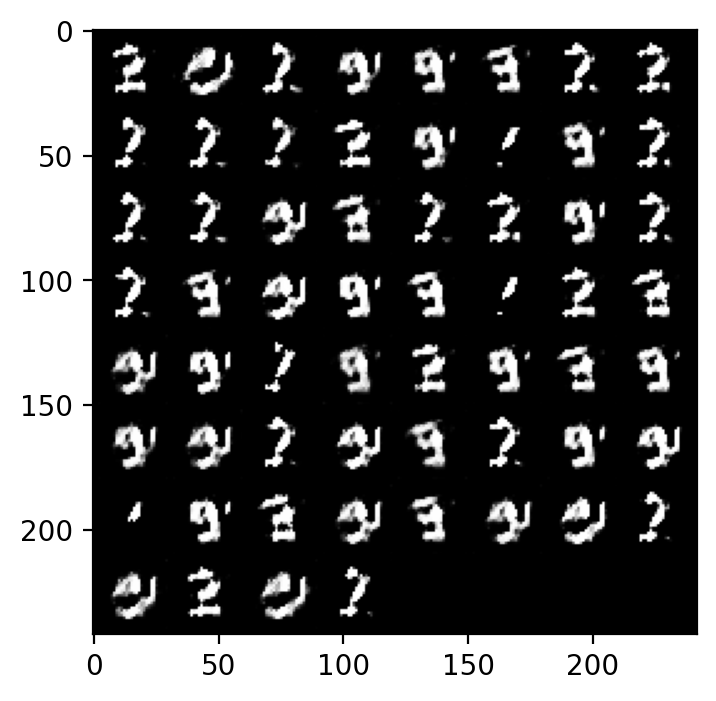

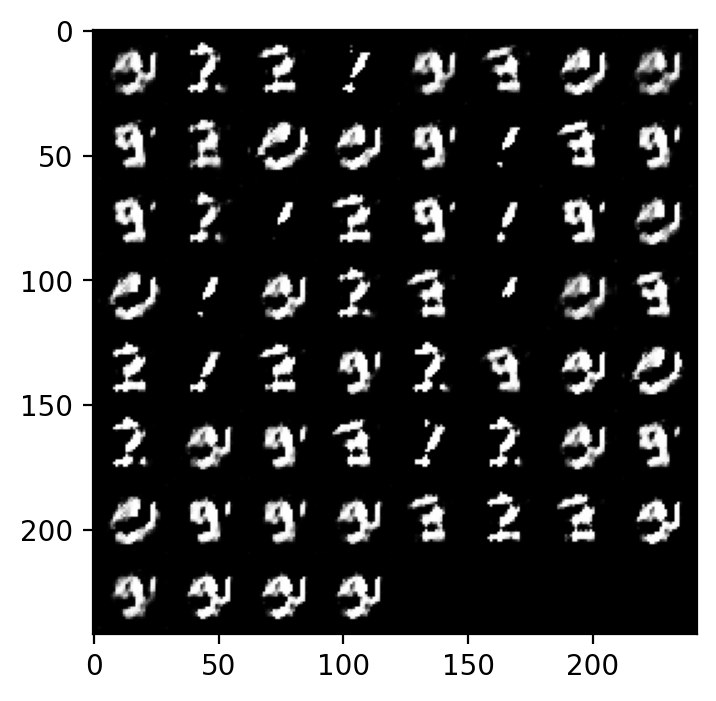

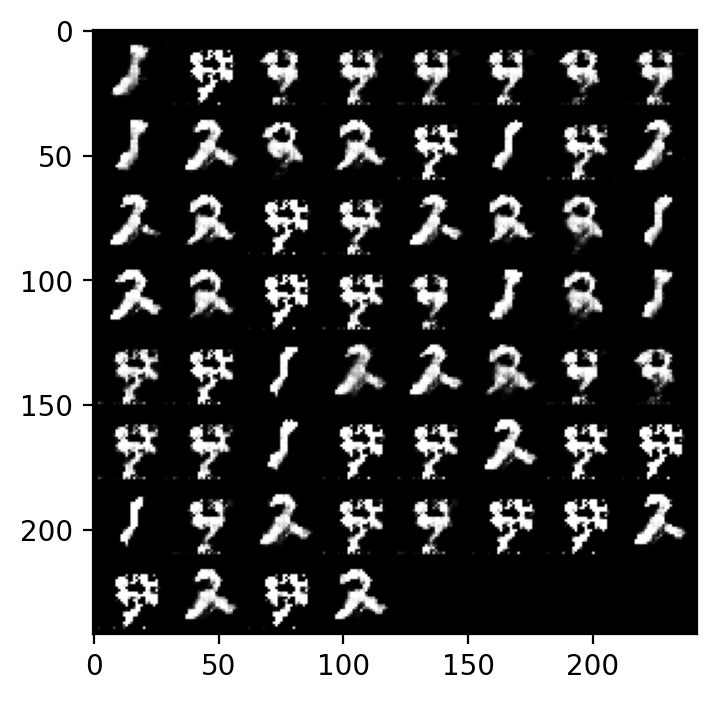

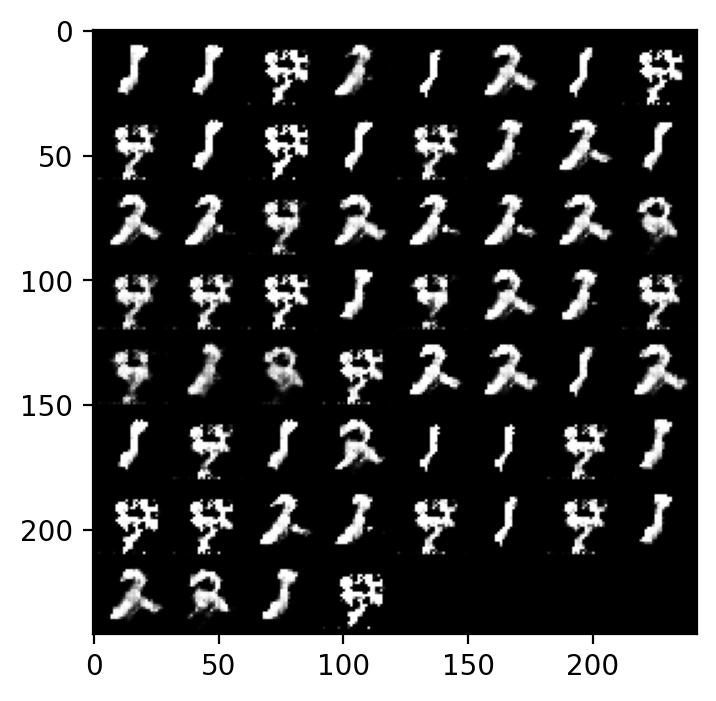

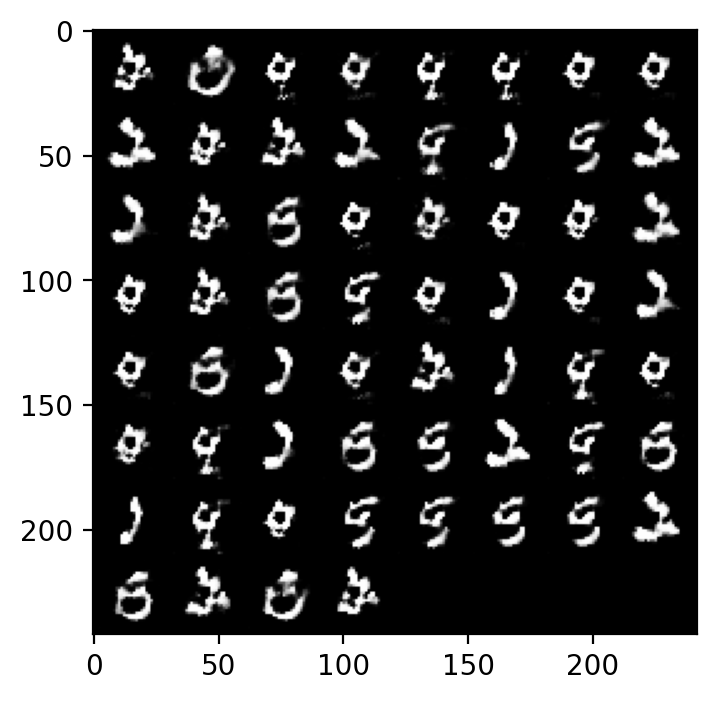

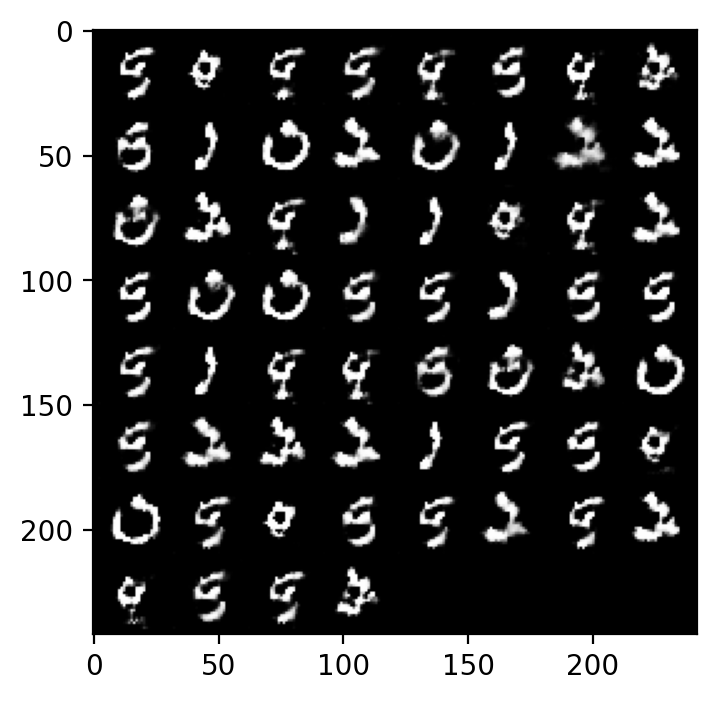

In [ ]:
train_CVAE_GAN(60,1,128,28,28,10,10,3e-4,15,data_loader_mnist)